### **Load Library And Models**

In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
import IPython.display as display
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from __future__ import print_function
import PIL.Image as Image
import matplotlib.pyplot as plt
import copy

use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

import torchvision.transforms.functional as F
from torchvision.utils import make_grid

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import cv2
from glob import glob
from tqdm import tqdm
from tensorflow.keras.utils import CustomObjectScope

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Functions**

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
def load_img(img):
  max_dim = 512
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [ ]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
def mask_content(content_img, generated_img, mask_img):
    width = mask_img.size(2)
    height = mask_img.size(3)
    mask_img = mask_img.data.cpu().numpy()
    content_img = content_img.data
    
    for i in range(width):
        for j in range(height):
            if mask_img[0, :, i, j].all() == 0:
                generated_img[0, :, i, j] = content_img[0, :, i, j]
    
    return generated_img

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

def image_loader(image_name):
    image=image_name
    if transform is not None:
        image = transform(image)
        
    image = Variable(image)
    image = image.unsqueeze(0)
    
    return image.type(dtype)

In [ ]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
def seg_image1(seg_path):
  """ Global parameters """
  H = 512
  W = 512

  """ Creating a directory """
  def create_dir(path):
      if not os.path.exists(path):
          os.makedirs(path)

  if __name__ == "__main__":
      """ Seeding """
      np.random.seed(42)
      tf.random.set_seed(42)

      """ Directory for storing files """
      create_dir("remove_bg")

      # model.summary()

      """ Load the dataset """
      data_x = glob(seg_path)

      for path in tqdm(data_x, total=len(data_x)):
          """ Extracting name """
          name = path.split("/")[-1].split(".")[0]

          """ Read the image """
          image = cv2.imread(path, cv2.IMREAD_COLOR)
          h, w, _ = image.shape
          x = cv2.resize(image, (W, H))
          x = x/255.0
          x = x.astype(np.float32)
          x = np.expand_dims(x, axis=0)

          """ Prediction """
          y = model.predict(x)[0]
          y = cv2.resize(y, (w, h))
          y = np.expand_dims(y, axis=-1)
          y = y > 0.5

          photo_mask = y
  return photo_mask*255

In [ ]:
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Data Science/model (2).h5")

### **Implementation**

In [ ]:
content_path='/content/drive/MyDrive/Colab Notebooks/Data Science/Famous-Bollywood-Actor-Akshay-Kumar.jpg'
style_path='/content/drive/MyDrive/Colab Notebooks/Data Science/edtaonisl.jpg'
style_path2='/content/drive/MyDrive/Colab Notebooks/Data Science/iStock-641678392.jpg'

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 7s 7s/step


100%|██████████| 1/1 [00:07<00:00,  7.16s/it]


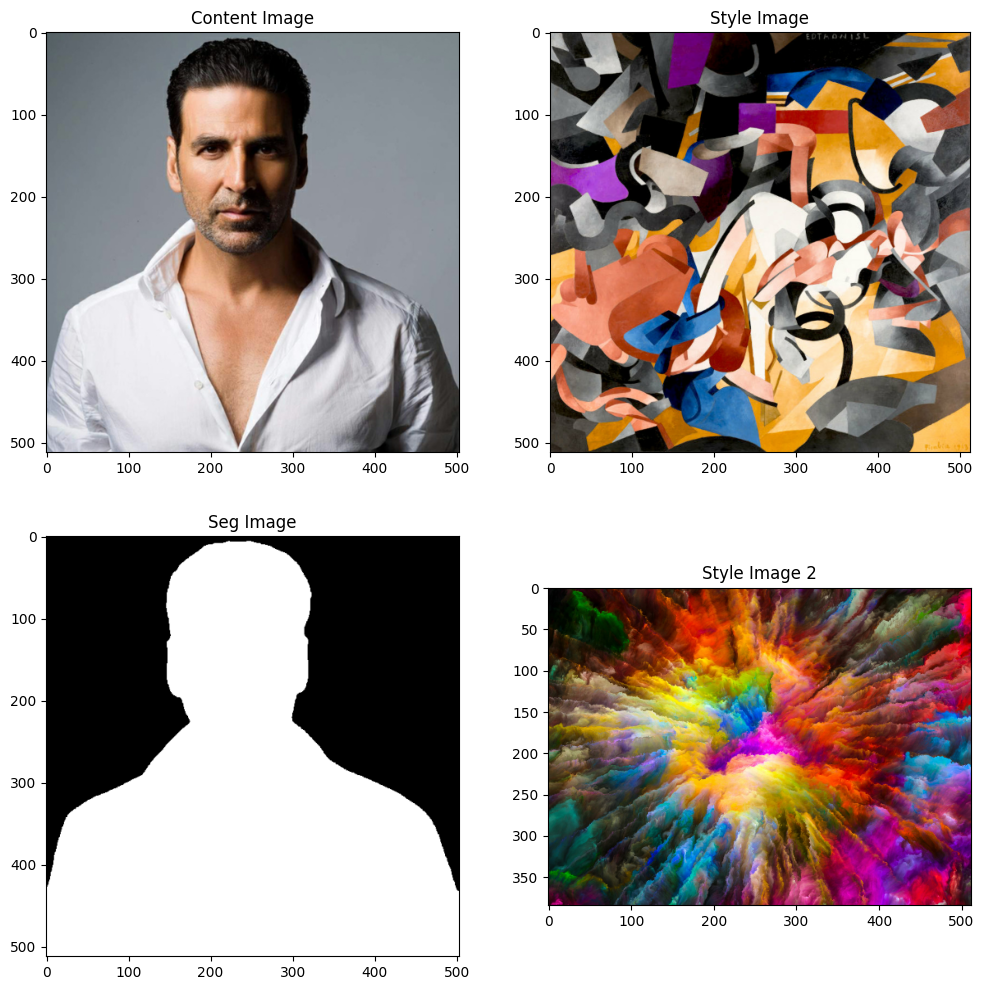

In [ ]:
content_image = load_img(tf.io.read_file(content_path))
style_image = load_img(tf.io.read_file(style_path))
style_image2 = load_img(tf.io.read_file(style_path2))
img_array_2d = np.squeeze(seg_image1(content_path), axis=2)  # Convert to a 2D array
img_array_2d = img_array_2d.astype(np.uint8)  # Convert to uint8
# Create a PIL Image object from the 2D ndarray
seg_img = Image.fromarray(img_array_2d)
seg_img.save('image.png')
seg_image = load_img(tf.io.read_file('image.png'))

plt.subplot(2, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(2, 2, 2)
imshow(style_image, 'Style Image')

plt.subplot(2, 2, 3)
imshow(seg_image, 'Seg Image')

plt.subplot(2, 2, 4)
imshow(style_image2, 'Style Image 2')

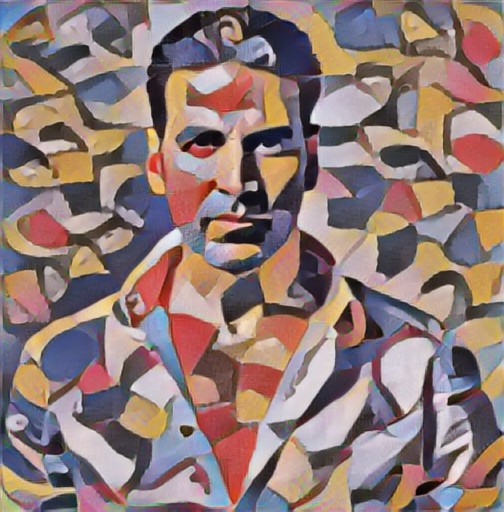

In [ ]:
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

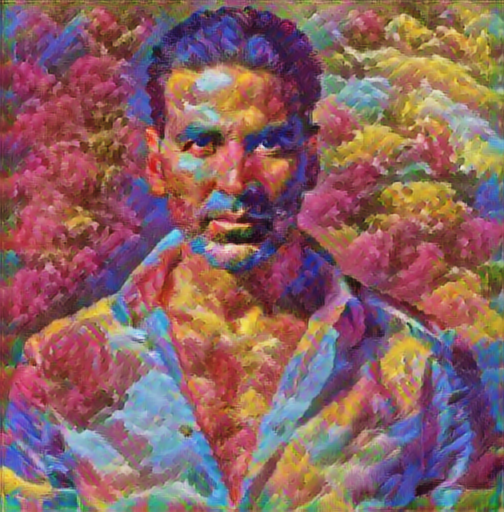

In [ ]:
stylized_image2 = hub_model(tf.constant(content_image), tf.constant(style_image2))[0]
tensor_to_image(stylized_image2)

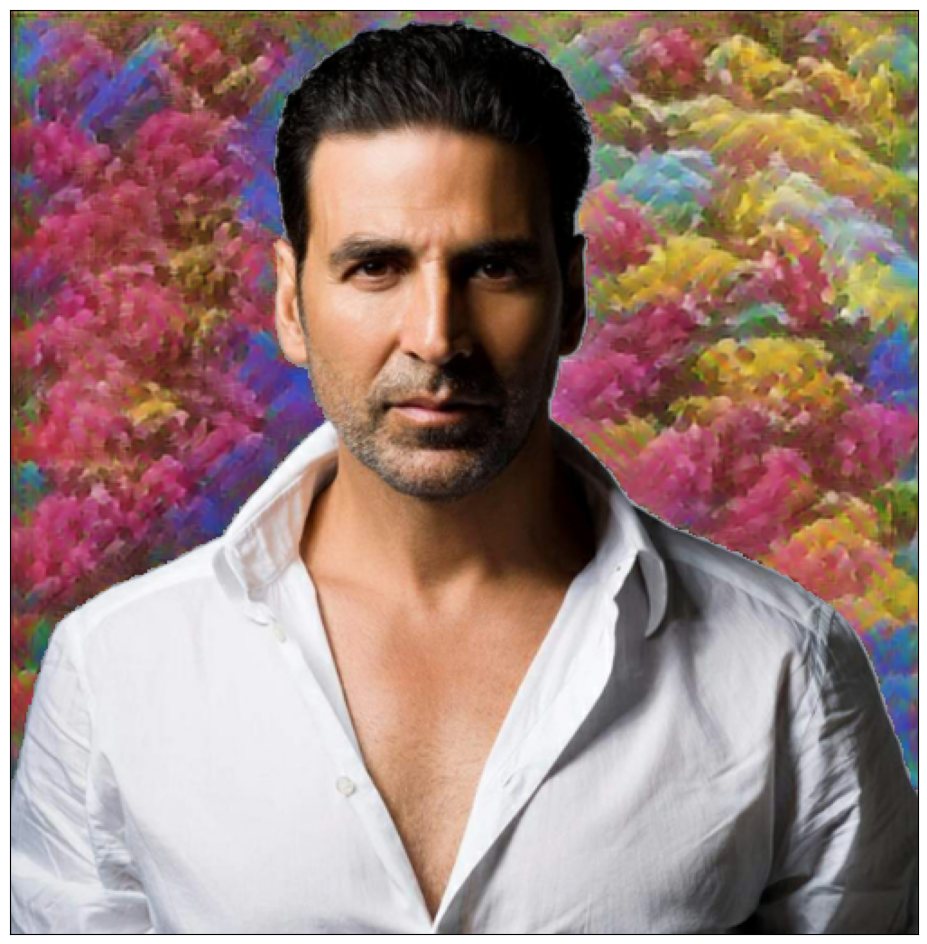

In [ ]:
output = mask_content(image_loader(tensor_to_image(stylized_image2)), image_loader(tensor_to_image(content_image)),image_loader(tensor_to_image(seg_image)) )
grid = make_grid(output)
show(grid)